# Introduction

We want our model to estimate election outcomes based on the fundamentals and poll data. Thus, we need a "poll feature" for each district upon which to train. Unfortunately, many districts do not have poll data. We overcome this by interpolating poll results for districts that do not have polls from districts that do have polls based on districts' similarity in demographics and historical election results.

In [1]:
print('starting')

import pandas as pd
import numpy as np
import scipy.cluster
import scipy.interpolate
from scipy import stats
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import matplotlib.pyplot as plt
from datetime import date
import thinkbayes2

plt.style.use('ggplot')

print('done')

starting
done


In [2]:
print('starting')

WEIGHTS = {'A': .177,
           'B': .151,
           'C': .130,
           'D': .077}

DAYDIV = 167

print('Done')

starting
Done


In [3]:
print('starting')

class Electorate(thinkbayes2.Suite):
    '''Represents hypotheses about the state of the electorate'''
    
    def Likelihood(self, data, hypo):
        '''
        Likelihood of the data under the hypothesis.

        hypo: fraction of the population
        data: poll results
        '''
        bias, std, result = data
        error = result - hypo
        like = thinkbayes2.EvalNormalPdf(error, bias, std)
        return like

class PollAggregator:
    '''Estimator of the poll distributions'''
    
    
    def __init__(self, N=1000):
        self.suite = Electorate(np.linspace(0, 1, N))
        self.poll_vals = []
        self.poll_sizes = []
    
    
    def update(self, val, grade, nsamp, days):
        self.poll_vals.append(val)
        self.poll_sizes.append(nsamp)
        
        pvs = np.array(self.poll_vals)
        pss = np.array(self.poll_sizes)
        stdev_shift = np.mean(np.sqrt(pvs * (1 - pvs) / pss))
        
        stdev = np.sqrt(val * (1 - val) / nsamp) + 0.01 / WEIGHTS[grade] - stdev_shift
        
        data = 0, stdev, val
        self.suite.Update(data)
        
        
    def display(self):
        pmf = np.array(list(self.suite.Items()))
        plt.plot(pmf[:,0], pmf[:,1])
    
    def e_val(self):
        pmf = np.array(list(self.suite.Items()))
        return np.dot(pmf[:,0], pmf[:,1])
    
print('Done')

starting
Done


In [4]:
print('starting')

districts = list(pd.read_csv('districts.csv', header=None).iloc[:,0])
poll_df = pd.read_excel('PoliStat polls (Responses).xlsx', sheet='Form Responses 1')

print('Done')

starting
Done


In [5]:
print('starting')

polls = {district: PollAggregator() for district in districts}
vanilla_weights = {district: [] for district in districts}

for index, row in poll_df.iterrows():
    name = row['District Name (e.g. AZ-03, WA-11)']
    val = row['Democratic percent (Not margin, not 2-party)']
    grade = row['Pollster Grade https://projects.fivethirtyeight.com/pollster-ratings/ (Put D if N/A)']
    
    year = int(str(row['Final date taken']).split(' ')[0].split('-')[0])
    month = int(str(row['Final date taken']).split(' ')[0].split('-')[1])
    day = int(str(row['Final date taken']).split(' ')[0].split('-')[2])
    d0 = date(year, month, day)
    d1 = date(2018, 11, 6)
    days = d1 - d0
    days = days.days
    
    nw = np.exp(days / 30)
    nsamp = row['Sample Size']
    
    polls[name].update(val, grade, nsamp, days)
    vanilla_weights[name].append(np.exp(days / 167) * WEIGHTS[grade])

for vw in vanilla_weights:
    if len(vanilla_weights[vw]) > 0:
        vanilla_weights[vw] = 1.8 / np.arctan(16.6 * np.sum(vanilla_weights[vw]))
    else:
        vanilla_weights[vw] = 0
    
print('Done')

starting
Done


starting
Done


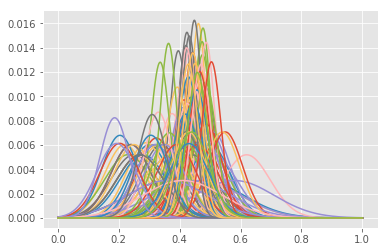

In [6]:
print('starting')

with open('ppoll.csv', 'w') as f:
    for poll in polls:
        if len(polls[poll].poll_vals) > 0:
            f.write(poll + ',' + str((polls[poll].e_val() - 0.5) * 100) + '\n')
            polls[poll].display()
        else:
            f.write(poll + ',' + '0\n')
            
print('Done')

# Input Data

We will now interpolate real polls based on a large range of input features. We predict based on ProximityOne's [demographic data by congressional district](http://proximityone.com/cd.htm). Specifically, we input a hand-selected set of [social characteristics](http://proximityone.com/cd161dp2.htm).

We partition this data set into districts that have polls and districts that do not have polls.

In [7]:
print('starting')

pp = pd.read_csv('ppoll.csv', header=None)
df = pd.read_excel('handmod.xlsx', sheet='Sheet 1', header=None)

ins = ['S' + str(rep).zfill(3) for rep in range(df.shape[1])]
outs = ['MRAM']

# Drop rows that have non-numerical data
df.dropna(inplace=True)
df = df[df.applymap(np.isreal).any(1)]
df.columns = ins
df['Name'] = districts
df['MRAM'] = pp.iloc[:,1]

# Make a copy of all the data before you drop the districts without polls
raw = df.copy(deep=True)

# Drop rows that down have MRAM
df = df[df['MRAM'] != 0]

print('done')

starting
done


# Training the Interpolator

We perform the interpolation using [radial basis function interpolation](http://num.math.uni-goettingen.de/schaback/teaching/sc.pdf) (RBF interpolation). Given a set of training points, the interpolator will learn a function to guess values for districts that do not have polls.

In [8]:
print('starting')

def gen_interpolator(df_train, _ins, _outs):
    inrep = [np.array(df_train[rep]).astype(float) for rep in _ins]
    outrep = [np.array(df_train[rep]).astype(float) for rep in _outs]
    features = list(inrep) + list(outrep)
    return scipy.interpolate.Rbf(*features)


def validate_step(rbfi, df_validate, _ins, _outs):
    y_pred = []
    y_true = []
    for index, row in df_validate.iterrows():
        y_pred.append(rbfi(*[row[rep] for rep in _ins]))
        y_true.append(row[outs[0]])

    er = np.array(np.array(y_true) - np.array(y_pred))
    correct = np.array([(y_pred[i] > 0.5) == (y_true[i] > 0.5) for i in range(len(y_pred))])
    
    return er, correct

print('done')

starting
done


# Cross Validation

In order to determine how good our interpolator is at guessing "poll values" for districts without polls, we test the interopolator on districts that do have polls. We do this by training the interpolator on a training data set that excludes some of the districts with polls, then uses that test interpolator to predict the poll values for the districts that were excluded. We may then compare the predicted values with the actual poll values, giving the error of our interpolation.

Here we split the available data into $\frac{114}{435}$ since when we go to predict the real polls, we have polls for 114 of the 435 districts.

starting
- 0.0% -- 10.0% -- 20.0% -- 30.0% -- 40.0% -- 50.0% -- 60.0% -- 70.0% -- 80.0% -- 90.0% -


Fraction of Races Predicted Correctly: 0.9368421052631579
Mean Squared Prediction Error: 64.76964831508691
Mean Absolute Prediction Error: 6.39904329028573
Mean Prediction Error: 2.8844742653790783
Stdev Prediction Error: 7.513285335154838


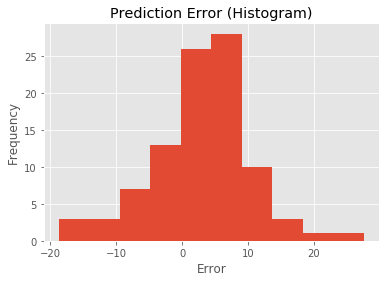

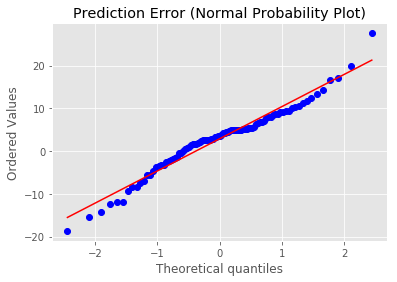

done


In [9]:
print('starting')

totcor = 0
er_all = []
correct_all = []

N = 1000
for k in range(N):
    # Randomly select training 
    ridx = np.random.rand(len(df)) < 114 / 435 # 50% True 50% False
    df_train = df[ridx]
    df_validate = df[~ridx]
    
    rbfi = gen_interpolator(df_train, ins, outs)
    er, correct = validate_step(rbfi, df_validate, ins, outs)
    
    er_all.append(er)
    correct_all.append(correct)
    
    if k % (N / 10) == 0:
        print('- ' + str(k / N * 100) + '% -', end='')

print()
print('\n\nFraction of Races Predicted Correctly: ' + str(np.sum(correct) / len(correct)))
print('Mean Squared Prediction Error: ' + str(np.mean(er ** 2)))
print('Mean Absolute Prediction Error: ' + str(np.mean(np.abs(er))))
print('Mean Prediction Error: ' + str(np.mean(er)))
print('Stdev Prediction Error: ' + str(np.std(er)))

plt.hist(er)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Prediction Error (Histogram)')
plt.show()

res = stats.probplot(er, plot=plt)
plt.title('Prediction Error (Normal Probability Plot)')
plt.show()

print('done')

# Calculating Interpolated Weights

In order to determine how much we should trust Blairvoyance and how much we should trust the fundamentals, we take a function of the cross validation error of the interpolator. Since each district has a different level of certainity, we will calculate separate weights for each district.

In [13]:
print('starting')

bads = []
bnames = []
for k in range(len(df)):
    ridx = np.ones(len(df), dtype=bool)
    ridx[k] = False
    
    df_train = df[ridx]
    df_validate = df[~ridx]
    
    rbfi = gen_interpolator(df_train, ins, outs)
    er, correct = validate_step(rbfi, df_validate, ins, outs)
    
    name = df_validate['Name'].iloc[0]
    
    bads.append(vanilla_weights[name] / np.abs(er))
    bnames.append(name)
#     print(name + ': ' + str(vanilla_weights[name] / er))    

bads = np.array(bads) / max(bads)

with open('bads.csv', 'w') as fbo:
    for k in range(len(bads)):
        fbo.write(bnames[k] + ',' + str(bads[k]) + '\n')

print('done')

starting
done


# Final Answer

We now plug in all available data to an interpolator and interpolate all rows. Keep in mind we expect our interpolation error to be drawn from the distribution shown above.

In [11]:
print('starting')

rbfi = gen_interpolator(df, ins, outs)

tidx = range(len(raw))
trows = [raw.iloc[idx] for idx in tidx]
y_pred = [(float(rbfi(*[row[rep] for rep in ins])) + 50) / 100 for row in trows]
print(y_pred)
np.savetxt('out.csv', (50 + np.array(y_pred)) / 100, delimiter=',')

print('done')

starting
[0.44471180040763103, 0.3242544138562573, 0.32198360247073365, 0.29294274649146645, 0.3575132468767384, 0.4077306834212388, 0.47520129052557364, 0.36110231021222605, 0.3611023102122266, 0.5, 0.42451016422150417, 0.2501528873933097, 0.3456588991691552, 0.41477242598987746, 0.44201710584419746, 0.3457661392485153, 0.4180466074101878, 0.22010346562876804, 0.41514512095289036, 0.31000044503289925, 0.2400361543385793, 0.3771667001527294, 0.47495891195194984, 0.47537163424624396, 0.3994783312010486, 0.46955566656498887, 0.496600812737355, 0.5, 0.455066731534846, 0.4920309922247679, 0.4843139800461131, 0.4965406073625877, 0.5171182840230483, 0.5256193230948327, 0.4876845597008753, 0.48211526154152123, 0.45885542835417825, 0.47646477932579956, 0.5092915461267421, 0.4758316619622792, 0.4743461698342804, 0.42455898910903445, 0.4204860525161337, 0.4684990281331085, 0.47006084705923057, 0.475061064815128, 0.48078050689675594, 0.46404495310268545, 0.4942186877315828, 0.4616738359892906, 0.